In [1]:
import torch
import torchvision
import torch.nn as nn
from IPython.display import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 12345
random.seed(seed)
torch.manual_seed(seed)
import numpy as np

In [2]:
# Part 1. For data loading and transformation, calculate means and standard deviations of the CIFAR-10 data
from torchvision import transforms

# Define a transform to convert the images to tensors
transform_to_tensor = transforms.Compose([transforms.ToTensor()])

cifar10_train = torchvision.datasets.CIFAR10(root='./cifar10',
                                             train=True,
                                             transform=transform_to_tensor,
                                             target_transform=None,
                                             download=True)

cifar10_test = torchvision.datasets.CIFAR10(root='./cifar10',
                                             train=False,
                                             transform=transform_to_tensor,
                                             target_transform=None,
                                             download=True)

# Divides the dataset into train and val so that we can use the val to choose our hyperparameters
train_dataset, val_dataset = torch.utils.data.random_split(cifar10_train, [40000, 10000],
                                                           generator=torch.Generator().manual_seed(12345))
test_dataset = cifar10_test

100%|██████████| 170498071/170498071 [00:13<00:00, 12881968.82it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10
Files already downloaded and verified


In [3]:
# Import necessary libraries
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm


# Define the function to compute mean and standard deviation
def get_mean_std(loader):
    # Initialize sums and count for mean calculation
    sum_rgb = torch.tensor([0.0, 0.0, 0.0])
    count = 0

    # Calculate the sum of pixel values for each channel
    for images, _ in tqdm(loader):
        sum_rgb += images.view(images.size(0), 3, -1).sum(dim=2).sum(dim=0)
        count += images.view(images.size(0), 3, -1).shape[2] * images.size(0)

    # Calculate means
    mean_rgb = sum_rgb / count

    # Initialize sum for variance calculation
    sum_var_rgb = torch.tensor([0.0, 0.0, 0.0])

    # Calculate the sum of squared differences from the mean
    for images, _ in tqdm(loader):
        sum_var_rgb += ((images.view(images.size(0), 3, -1) - mean_rgb.unsqueeze(1)) ** 2).sum(dim=2).sum(dim=0)

    # Calculate variance and standard deviation
    var_rgb = sum_var_rgb / count
    std_rgb = torch.sqrt(var_rgb)

    return mean_rgb, std_rgb

# Define the DataLoader for the CIFAR-10 training dataset
# 40000 / 64 = 625. Each batch has 625 images.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=False)

In [4]:
# Compute the mean and standard deviation
mean, std = get_mean_std(train_loader)

print(f"\nMean: {mean}")
print(f"Standard Deviation: {std}")

100%|██████████| 625/625 [00:05<00:00, 113.85it/s]


Mean: tensor([0.4907, 0.4816, 0.4461])
Standard Deviation: tensor([0.2469, 0.2432, 0.2613])


In [5]:
# dataset is a random batch from train_loader with batch size = 64
# compute mean of red, mean of green, mean of blue. Also standard deviation of red, green, and blue
print(f'This batch has means of RGB: {mean[0]}, {mean[1]}, {mean[2]}')
print(f'This batch has stadard deviations of RGB: {std[0]}, {std[1]}, {std[2]}')


This batch has means of RGB: 0.49071556329727173, 0.48164132237434387, 0.4460550844669342
This batch has stadard deviations of RGB: 0.24687588214874268, 0.24322731792926788, 0.2613436281681061


In [6]:
# Part 2. CIFAR-10 data loading and transformation
# Data loading and transformation
transform_train = transforms.Compose([

    # the CIFAR-10 image is 32 x 32 pixels.
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((mean[0], mean[1], mean[2]), (std[0], std[1], std[2])),
])

# Normalization
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean[0], mean[1], mean[2]), (std[0], std[1], std[2])),
])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

In [16]:
# Part 3: function implementation - residual block
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import torch.nn.functional as F

class ResidualBlock_3blocks(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(ResidualBlock_3blocks, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

class ResNet18ThreeLayersThreeBlocks_64channels(nn.Module):
    def __init__(self, block=ResidualBlock_3blocks, in_channel_size=3, num_blocks_array=[3,3,3], out_channel_size=64, num_classes=10):
        super(ResNet18ThreeLayersThreeBlocks_64channels, self).__init__()
        self.in_channels = out_channel_size

        # Initial convolution
        self.conv = nn.Conv2d(in_channel_size, out_channel_size, kernel_size=5, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channel_size)
        self.relu = nn.ReLU(inplace=True)

        # Creating three layers with three blocks each
        self.layer1 = self._make_layer(block, out_channel_size, num_blocks_array[0])
        self.layer2 = self._make_layer(block, out_channel_size*2, num_blocks_array[1], stride=2)
        self.layer3 = self._make_layer(block, out_channel_size*4, num_blocks_array[2], stride=2)

        # Adaptive pooling and fully connected layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #self.fc = nn.Linear(out_channel_size*4*2*2, num_classes)  # 注意这里

        self.fc = nn.Linear(out_channel_size*4, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride=stride, downsample=downsample))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn(self.conv(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [17]:
model = ResNet18ThreeLayersThreeBlocks_64channels()

# compute the number of parameters in this model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Default model has the total number(million) of parameters: {total_params/10**6}")

Default model has the total number(million) of parameters: 4.330826


In [55]:
import torch
import torch.optim as optim
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Assuming model is defined and device is set
# Example model instantiation and device setup
# model = ResNet18ThreeLayersThreeBlocks_64channels().to(device)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model instantiation with the correct in_channel_size
model = ResNet18ThreeLayersThreeBlocks_64channels().to(device)

def train_model(model, optimizer, criterion, trainloader, num_epochs, gamma=0.1, step_size=5):
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number(million) of trainable parameters: {total_params/10**6}")

    # Setup the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for i, data in enumerate(tqdm(trainloader, total=len(trainloader), unit='batch', desc=f"Epoch {epoch+1}")):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()
        average_loss = running_loss / len(trainloader)
        losses.append(average_loss)

        # Print running loss at the end of the epoch
        tqdm.write(f'\nAverage Loss: {running_loss / len(trainloader):.3f}')
        tqdm.write(f'Number(mil) of parameters: {total_params/10**6}')
        tqdm.write(f'Finished Training {epoch + 1}\n')

        # Step the scheduler
        scheduler.step()

        print('Finished Training')
        return losses


In [56]:
# Usage example with SGD
model = ResNet18ThreeLayersThreeBlocks_64channels()  #
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
num_epochs=10
losses = train_model(model, optimizer_sgd, criterion, trainloader, num_epochs)

Total number(million) of trainable parameters: 4.330826


Epoch 1:   0%|          | 0/313 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 48.98batch/s]


Average Loss: 1.417
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training


In [27]:
from tqdm import tqdm

def test_model(model, testloader):
    model.eval()  # Set the model to evaluation mode
    device = next(model.parameters()).device  # Get the device model is on

    total = 0
    correct = 0

    with torch.no_grad():  # No need to track gradients during testing
        for data in tqdm(testloader, total=len(testloader), desc="Testing"):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate and print the accuracy
    accuracy = 100 * correct / total
    print(f'\nAccuracy of the network on the test images: {accuracy:.2f}%')

    return accuracy

In [28]:
# Assuming model and testloader are defined
test_accuracy = test_model(model, testloader)

Testing: 100%|██████████| 100/100 [00:00<00:00, 108.38it/s]


Accuracy of the network on the test images: 58.18%


In [30]:
import torch.optim as optim
import torch.nn as nn

def train_and_test(model_func, epochs_array, trainloader, testloader, criterion, optimizer_func, lr = 0.001):
    for num_epochs in epochs_array:
        if num_epochs == 0:  # Skip if the number of epochs is 0
            continue

        # Initialize the model for each run
        model = model_func().to(device)



        # Initialize the optimizer with the current model parameters and learning rate
        optimizer = optimizer_func(model.parameters(), lr=lr)

        # Training the model
        print(f"\nTraining for {num_epochs} epochs...")
        train_model(model, optimizer, criterion, trainloader, num_epochs)

        # Testing the model
        test_accuracy = test_model(model, testloader)

        # Compute the number of parameters in this model
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f'Optimizer: {optimizer_func.__name__}')
        print(f'Learning rate: {lr}')
        print(f'Number of epochs: {num_epochs})')
        print(f'After applying epochs = {num_epochs}, accuracy of the network on the test images: {test_accuracy:.2f}%, with number(mil) of parameters = {total_params/10**6}\n')

In [51]:
def train_model_gamma(model, optimizer, criterion, trainloader, num_epochs, gamma, step_size):
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total number(million) of trainable parameters: {total_params/10**6}")

    # Setup the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)


    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0


        for i, data in enumerate(tqdm(trainloader, total=len(trainloader), unit='batch', desc=f"Epoch {epoch+1}")):
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()


        # Print running loss at the end of the epoch
        tqdm.write(f'\nAverage Loss: {running_loss / len(trainloader):.3f}')
        tqdm.write(f'Finished Training {epoch + 1}\n')

        # Step the scheduler
        scheduler.step()


        print('Finished Training')
        return losses

In [68]:
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Average Loss per Epoch')
    plt.legend()
    plt.savefig('loss_curve_gamma=0.5_stepsieze10.png')
    plt.grid(True)
    plt.show()


Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 48.89batch/s]



Average Loss: 1.424
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.70batch/s]



Average Loss: 0.957
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.55batch/s]



Average Loss: 0.729
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.62batch/s]



Average Loss: 0.594
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.32batch/s]



Average Loss: 0.499
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.81batch/s]



Average Loss: 0.423
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.40batch/s]



Average Loss: 0.354
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.26batch/s]



Average Loss: 0.296
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.48batch/s]



Average Loss: 0.238
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.09batch/s]



Average Loss: 0.192
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 51.25batch/s]



Average Loss: 0.149
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.60batch/s]



Average Loss: 0.121
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 48.77batch/s]



Average Loss: 0.093
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.61batch/s]



Average Loss: 0.084
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.06batch/s]



Average Loss: 0.066
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.84batch/s]



Average Loss: 0.068
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 47.54batch/s]



Average Loss: 0.055
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 48.56batch/s]



Average Loss: 0.060
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.98batch/s]



Average Loss: 0.043
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 51.20batch/s]



Average Loss: 0.051
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.38batch/s]



Average Loss: 0.048
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 48.32batch/s]



Average Loss: 0.040
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.16batch/s]



Average Loss: 0.039
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.42batch/s]



Average Loss: 0.038
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.94batch/s]



Average Loss: 0.027
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.23batch/s]



Average Loss: 0.038
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.80batch/s]



Average Loss: 0.041
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.77batch/s]



Average Loss: 0.024
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.40batch/s]



Average Loss: 0.031
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.58batch/s]



Average Loss: 0.030
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training


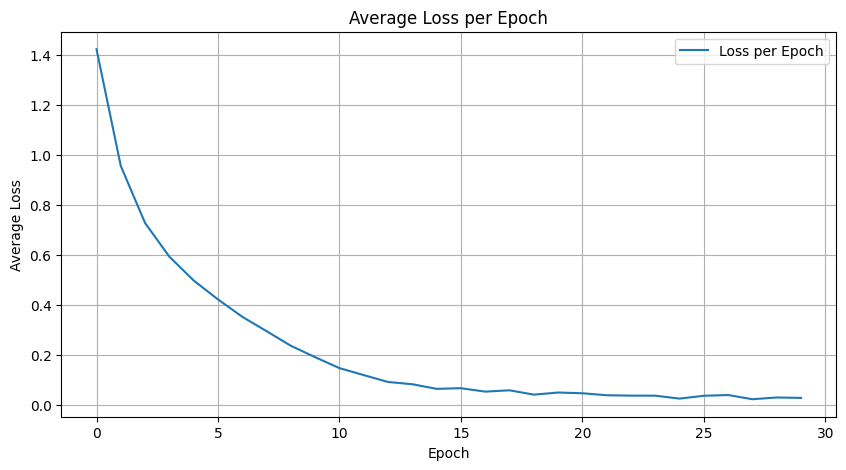

In [69]:
model = ResNet18ThreeLayersThreeBlocks_64channels()  #
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs=30
losses = []
for i in range(num_epochs):
  each_losses  = train_model(model, optimizer, criterion, trainloader, num_epochs, gamma=0.5, step_size=10)
  losses.append(each_losses)

plot_losses(losses)

In [32]:
# This one
# Example usage
train_and_test(
    lambda: ResNet18ThreeLayersThreeBlocks_64channels(),
    [30],
    trainloader,
    testloader,
    nn.CrossEntropyLoss(),
    optim.Adam,
    0.001
)



Training for 10 epochs...
Total number(million) of trainable parameters: 4.330826


Epoch 1:   0%|          | 0/313 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.32batch/s]



Average Loss: 1.444
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training


Epoch 2: 100%|██████████| 313/313 [00:06<00:00, 50.54batch/s]



Average Loss: 0.961
Number(mil) of parameters: 4.330826
Finished Training 2

Finished Training


Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 50.51batch/s]



Average Loss: 0.739
Number(mil) of parameters: 4.330826
Finished Training 3

Finished Training


Epoch 4: 100%|██████████| 313/313 [00:06<00:00, 50.96batch/s]



Average Loss: 0.605
Number(mil) of parameters: 4.330826
Finished Training 4

Finished Training


Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 50.81batch/s]



Average Loss: 0.502
Number(mil) of parameters: 4.330826
Finished Training 5

Finished Training


Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 51.41batch/s]



Average Loss: 0.314
Number(mil) of parameters: 4.330826
Finished Training 6

Finished Training


Epoch 7: 100%|██████████| 313/313 [00:06<00:00, 50.40batch/s]



Average Loss: 0.259
Number(mil) of parameters: 4.330826
Finished Training 7

Finished Training


Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 51.47batch/s]



Average Loss: 0.225
Number(mil) of parameters: 4.330826
Finished Training 8

Finished Training


Epoch 9: 100%|██████████| 313/313 [00:06<00:00, 50.57batch/s]



Average Loss: 0.194
Number(mil) of parameters: 4.330826
Finished Training 9

Finished Training


Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 50.67batch/s]



Average Loss: 0.162
Number(mil) of parameters: 4.330826
Finished Training 10

Finished Training


Testing: 100%|██████████| 100/100 [00:00<00:00, 107.72it/s]



Accuracy of the network on the test images: 84.51%
Optimizer: Adam
Learning rate: 0.001
Number of epochs: 10)
After applying epochs = 10, accuracy of the network on the test images: 84.51%, with number(mil) of parameters = 4.330826


Training for 20 epochs...
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 49.59batch/s]



Average Loss: 1.494
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training


Epoch 2: 100%|██████████| 313/313 [00:06<00:00, 50.58batch/s]



Average Loss: 1.030
Number(mil) of parameters: 4.330826
Finished Training 2

Finished Training


Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 50.75batch/s]



Average Loss: 0.806
Number(mil) of parameters: 4.330826
Finished Training 3

Finished Training


Epoch 4: 100%|██████████| 313/313 [00:06<00:00, 49.91batch/s]



Average Loss: 0.651
Number(mil) of parameters: 4.330826
Finished Training 4

Finished Training


Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 50.32batch/s]



Average Loss: 0.543
Number(mil) of parameters: 4.330826
Finished Training 5

Finished Training


Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 50.21batch/s]



Average Loss: 0.348
Number(mil) of parameters: 4.330826
Finished Training 6

Finished Training


Epoch 7: 100%|██████████| 313/313 [00:06<00:00, 49.55batch/s]



Average Loss: 0.287
Number(mil) of parameters: 4.330826
Finished Training 7

Finished Training


Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 50.65batch/s]



Average Loss: 0.254
Number(mil) of parameters: 4.330826
Finished Training 8

Finished Training


Epoch 9: 100%|██████████| 313/313 [00:06<00:00, 50.36batch/s]



Average Loss: 0.218
Number(mil) of parameters: 4.330826
Finished Training 9

Finished Training


Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 50.45batch/s]



Average Loss: 0.186
Number(mil) of parameters: 4.330826
Finished Training 10

Finished Training


Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 50.15batch/s]



Average Loss: 0.140
Number(mil) of parameters: 4.330826
Finished Training 11

Finished Training


Epoch 12: 100%|██████████| 313/313 [00:06<00:00, 51.05batch/s]



Average Loss: 0.132
Number(mil) of parameters: 4.330826
Finished Training 12

Finished Training


Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 50.19batch/s]



Average Loss: 0.127
Number(mil) of parameters: 4.330826
Finished Training 13

Finished Training


Epoch 14: 100%|██████████| 313/313 [00:06<00:00, 51.35batch/s]



Average Loss: 0.124
Number(mil) of parameters: 4.330826
Finished Training 14

Finished Training


Epoch 15: 100%|██████████| 313/313 [00:06<00:00, 50.61batch/s]



Average Loss: 0.119
Number(mil) of parameters: 4.330826
Finished Training 15

Finished Training


Epoch 16: 100%|██████████| 313/313 [00:06<00:00, 50.98batch/s]



Average Loss: 0.113
Number(mil) of parameters: 4.330826
Finished Training 16

Finished Training


Epoch 17: 100%|██████████| 313/313 [00:06<00:00, 50.22batch/s]



Average Loss: 0.113
Number(mil) of parameters: 4.330826
Finished Training 17

Finished Training


Epoch 18: 100%|██████████| 313/313 [00:06<00:00, 49.61batch/s]



Average Loss: 0.112
Number(mil) of parameters: 4.330826
Finished Training 18

Finished Training


Epoch 19: 100%|██████████| 313/313 [00:06<00:00, 50.14batch/s]



Average Loss: 0.112
Number(mil) of parameters: 4.330826
Finished Training 19

Finished Training


Epoch 20: 100%|██████████| 313/313 [00:06<00:00, 49.69batch/s]



Average Loss: 0.112
Number(mil) of parameters: 4.330826
Finished Training 20

Finished Training


Testing: 100%|██████████| 100/100 [00:00<00:00, 105.49it/s]



Accuracy of the network on the test images: 84.74%
Optimizer: Adam
Learning rate: 0.001
Number of epochs: 20)
After applying epochs = 20, accuracy of the network on the test images: 84.74%, with number(mil) of parameters = 4.330826


Training for 30 epochs...
Total number(million) of trainable parameters: 4.330826


Epoch 1: 100%|██████████| 313/313 [00:06<00:00, 50.40batch/s]



Average Loss: 1.459
Number(mil) of parameters: 4.330826
Finished Training 1

Finished Training


Epoch 2: 100%|██████████| 313/313 [00:06<00:00, 50.54batch/s]



Average Loss: 1.016
Number(mil) of parameters: 4.330826
Finished Training 2

Finished Training


Epoch 3: 100%|██████████| 313/313 [00:06<00:00, 50.87batch/s]



Average Loss: 0.824
Number(mil) of parameters: 4.330826
Finished Training 3

Finished Training


Epoch 4: 100%|██████████| 313/313 [00:06<00:00, 49.64batch/s]



Average Loss: 0.676
Number(mil) of parameters: 4.330826
Finished Training 4

Finished Training


Epoch 5: 100%|██████████| 313/313 [00:06<00:00, 50.88batch/s]



Average Loss: 0.566
Number(mil) of parameters: 4.330826
Finished Training 5

Finished Training


Epoch 6: 100%|██████████| 313/313 [00:06<00:00, 50.10batch/s]



Average Loss: 0.369
Number(mil) of parameters: 4.330826
Finished Training 6

Finished Training


Epoch 7: 100%|██████████| 313/313 [00:06<00:00, 46.79batch/s]



Average Loss: 0.316
Number(mil) of parameters: 4.330826
Finished Training 7

Finished Training


Epoch 8: 100%|██████████| 313/313 [00:06<00:00, 50.44batch/s]



Average Loss: 0.281
Number(mil) of parameters: 4.330826
Finished Training 8

Finished Training


Epoch 9: 100%|██████████| 313/313 [00:06<00:00, 50.85batch/s]



Average Loss: 0.250
Number(mil) of parameters: 4.330826
Finished Training 9

Finished Training


Epoch 10: 100%|██████████| 313/313 [00:06<00:00, 50.44batch/s]



Average Loss: 0.221
Number(mil) of parameters: 4.330826
Finished Training 10

Finished Training


Epoch 11: 100%|██████████| 313/313 [00:06<00:00, 50.40batch/s]



Average Loss: 0.171
Number(mil) of parameters: 4.330826
Finished Training 11

Finished Training


Epoch 12: 100%|██████████| 313/313 [00:06<00:00, 48.93batch/s]



Average Loss: 0.164
Number(mil) of parameters: 4.330826
Finished Training 12

Finished Training


Epoch 13: 100%|██████████| 313/313 [00:06<00:00, 50.33batch/s]



Average Loss: 0.158
Number(mil) of parameters: 4.330826
Finished Training 13

Finished Training


Epoch 14: 100%|██████████| 313/313 [00:06<00:00, 51.11batch/s]



Average Loss: 0.153
Number(mil) of parameters: 4.330826
Finished Training 14

Finished Training


Epoch 15:  23%|██▎       | 73/313 [00:01<00:04, 48.86batch/s]


KeyboardInterrupt: 